In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/mrigaankjaswal/crop-yield-prediction-dataset/yield_df.csv


# Preparing Dataset

In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrigaankjaswal/crop-yield-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/d/mrigaankjaswal/crop-yield-prediction-dataset


In [37]:
dataset = pd.read_csv(f'{path}/yield_df.csv')
dataset.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [38]:
print(dataset.columns)
print(dataset.shape)

Index(['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp'],
      dtype='object')
(28242, 8)


In [39]:
non_numeric_cols = ['Area', 'Item']
for col in non_numeric_cols:
    unique_count = dataset[col].nunique()
    print(f"{col}: {unique_count} unique values")

Area: 101 unique values
Item: 10 unique values


In [40]:
cols_to_drop = ['Unnamed: 0']
dataset = dataset.drop(columns=cols_to_drop)
dataset.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [41]:
from sklearn.preprocessing import LabelEncoder

# Label encode
le = LabelEncoder()
dataset['Item_encoded'] = le.fit_transform(dataset['Item'])
dataset['Area_encoded'] = le.fit_transform(dataset['Area'])

In [42]:
feature_cols = ['Area_encoded', 'Item_encoded', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'Year']
target_col = 'hg/ha_yield'
timestamp_col = 'Year'

In [43]:
dataset = dataset.sort_values(by=['Area', 'Year'])
dataset.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Item_encoded,Area_encoded
0,Albania,Maize,1990,36613,1485.0,121.0,16.37,1,0
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37,3,0
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37,4,0
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37,5,0
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37,6,0


# Process train and test data

In [44]:
# normalize all features (including target)

from sklearn.preprocessing import MinMaxScaler

# Scale features
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(dataset[feature_cols])

# Scale target
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(dataset[[target_col]])  # double brackets for 2D shape

# Combine scaled features and target
import numpy as np
scaled_data = np.hstack([scaled_features, scaled_target])  # horizontal stack

# Create a dataframe with correct column names
scaled_df = pd.DataFrame(scaled_data, columns=feature_cols + [target_col])
scaled_df.head()

,Area_encoded,Item_encoded,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Year,hg/ha_yield
0,0.0,0.111111,0.449671,0.000329,0.513458,0.0,0.072927
1,0.0,0.333333,0.449671,0.000329,0.513458,0.0,0.132872
2,0.0,0.444444,0.449671,0.000329,0.513458,0.0,0.046439
3,0.0,0.555556,0.449671,0.000329,0.513458,0.0,0.024832
4,0.0,0.666667,0.449671,0.000329,0.513458,0.0,0.013862


In [45]:
# sliding window
def create_grouped_sequences(data, group_col, target_col, seq_length, feature_cols):
    X, y = [], []

    for _, group_df in data.groupby(group_col):
        group_df = group_df.sort_values(by='Year')  # Ensure time order
        group_df = group_df.reset_index(drop=True)

        for i in range(len(group_df) - seq_length):
            seq_x = group_df.loc[i:i+seq_length-1, feature_cols].values
            seq_y = group_df.loc[i+seq_length, target_col]
            X.append(seq_x)
            y.append(seq_y)

    return np.array(X), np.array(y)


In [46]:
seq_length = 5

X, y = create_grouped_sequences(scaled_df, group_col='Area_encoded', target_col=target_col,
                                seq_length=seq_length, feature_cols=feature_cols)

print("X shape:", X.shape) # 27737 samples, 5 timesteps, 6 features per timestep
print("y shape:", y.shape)

X shape: (27737, 5, 6)
y shape: (27737,)


In [47]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [49]:
print(X_train[:5]) 

[[[6.70000000e-01 3.33333333e-01 4.54374412e-01 9.02637015e-04
   4.99488927e-01 8.69565217e-01]
  [6.70000000e-01 4.44444444e-01 4.54374412e-01 9.02637015e-04
   4.99488927e-01 8.69565217e-01]
  [6.70000000e-01 6.66666667e-01 4.54374412e-01 9.02637015e-04
   4.99488927e-01 8.69565217e-01]
  [6.70000000e-01 1.11111111e-01 4.54374412e-01 9.32301653e-04
   4.70868825e-01 9.13043478e-01]
  [6.70000000e-01 3.33333333e-01 4.54374412e-01 9.32301653e-04
   4.70868825e-01 9.13043478e-01]]

 [[2.20000000e-01 0.00000000e+00 1.00000000e+00 2.24154324e-01
   8.90971039e-01 7.39130435e-01]
  [2.20000000e-01 1.11111111e-01 1.00000000e+00 2.24154324e-01
   8.90971039e-01 7.39130435e-01]
  [2.20000000e-01 1.00000000e+00 1.00000000e+00 2.24154324e-01
   8.90971039e-01 7.39130435e-01]
  [2.20000000e-01 8.88888889e-01 1.00000000e+00 2.24154324e-01
   7.21635434e-01 7.39130435e-01]
  [2.20000000e-01 8.88888889e-01 1.00000000e+00 2.24154324e-01
   8.90971039e-01 7.39130435e-01]]

 [[6.50000000e-01 8.888888

# Building Model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [52]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 64)               │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0291 - val_loss: 0.0252
Epoch 2/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0264 - val_loss: 0.0247
Epoch 3/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0258 - val_loss: 0.0238
Epoch 4/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 5/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0242 - val_loss: 0.0229
Epoch 6/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0235 - val_loss: 0.0223
Epoch 7/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0233 - val_loss: 0.0220
Epoch 8/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0229 - val_loss: 0.0216
Epoch 9/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0227 - val_loss: 0.0213
Epoch 10/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0219 - val_loss: 0.0209
Epoch 11/50
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0223 - val_loss: 0.0207
Epoch 12/50
1387/1387 ━━━━━━━

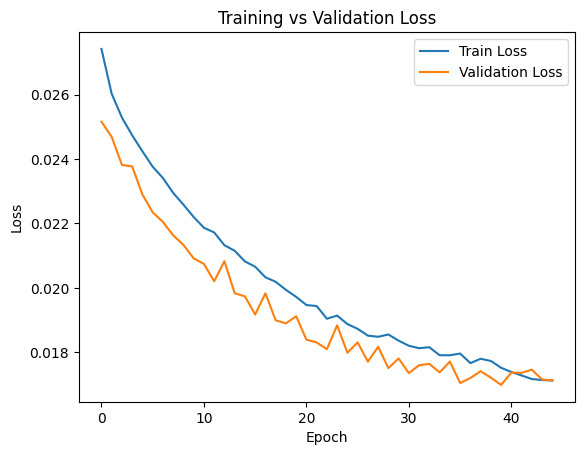

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Export Model 

In [54]:
model.save('lstm_yield_model.h5')

In [55]:
from sklearn.preprocessing import LabelEncoder

# Create separate encoders
le_item = LabelEncoder()
le_area = LabelEncoder()

dataset['Item_encoded'] = le_item.fit_transform(dataset['Item'])
dataset['Area_encoded'] = le_area.fit_transform(dataset['Area'])

In [56]:
# save label encoders and scaler

import joblib

joblib.dump(le_item, 'label_encoder_item.pkl')
joblib.dump(le_area, 'label_encoder_area.pkl')

joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')

['scaler_target.pkl']

In [57]:
# build a preprocessing pipeline function

le_item = joblib.load('label_encoder_item.pkl')
le_area = joblib.load('label_encoder_area.pkl')

scaler_features = joblib.load('scaler_features.pkl')
scaler_target = joblib.load('scaler_target.pkl')

def preprocess_input(area, item, rainfall, pesticides, temp, year, le_area, le_item, scaler, seq_length=5):
    """
    Preprocess the new input data for LSTM prediction including the `Year` feature.
    
    Parameters:
    - area: string (e.g. 'India')
    - item: string (e.g. 'Maize')
    - rainfall, pesticides, temp: floats (feature values)
    - year: int (year feature)
    - le_area, le_item: label encoders for Area and Item
    - scaler: the pre-trained scaler used for normalization
    - seq_length: the length of the input sequence for LSTM
    
    Returns:
    - full_sequence_scaled: the preprocessed input for LSTM (scaled and reshaped)
    """
    
    # Encode the area and item (using the pre-trained label encoders)
    area_encoded = le_area.transform([area])[0]
    item_encoded = le_item.transform([item])[0]
    
    # Prepare the new row (latest input) including the `Year` as a feature
    final_row = [area_encoded, item_encoded, rainfall, pesticides, temp, year]
    
    # Convert the final_row into a 2D array for scaling
    final_row_array = np.array([final_row])  # Shape: (1, 6) - 6 features now
    
    # Scale the final row (all 6 features)
    full_sequence_scaled = scaler.transform(final_row_array)  # Now includes the 'Year' feature
    
    # Reshape for LSTM input (1, 1, num_features)
    return full_sequence_scaled.reshape(1, 1, final_row_array.shape[1])

In [58]:
from tensorflow.keras.models import load_model

model = load_model('lstm_yield_model.h5')

In [59]:
area = 'Albania'
item = 'Maize'
rainfall = 1485.0
pesticides = 121.0
temp = 16.37
year = 1991

preprocessed_data = preprocess_input(area, item, rainfall, pesticides, temp, year, le_area, le_item, scaler_features)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [61]:
prediction = model.predict(preprocessed_data)
actual_pred = scaler_target.inverse_transform(prediction)
print(actual_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[102687.484]]
